In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ast
import itertools
import seaborn as sns
import os
import glob
import pandas as pd
import os
import re

#### Transaction Delay - builder_censorship_ratio (only strict censoring builders, strict_builder_ratio=1)

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_only_strict_builder_censorship_ratio_20250622_083425"

combined_transactions = pd.DataFrame()

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]

def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"bcr_{builder_ratio:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)

negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   bcr_0.000  Non-sanctioned (0)  37.911197  124.084247
1   bcr_0.000      Sanctioned (1)  47.741898  139.324714
2   bcr_0.050  Non-sanctioned (0)  20.921614   41.985614
3   bcr_0.050      Sanctioned (1)  34.263519   95.982698
4   bcr_0.100  Non-sanctioned (0)  18.777613   27.167758
5   bcr_0.100      Sanctioned (1)  29.423996   69.562246
6   bcr_0.200  Non-sanctioned 

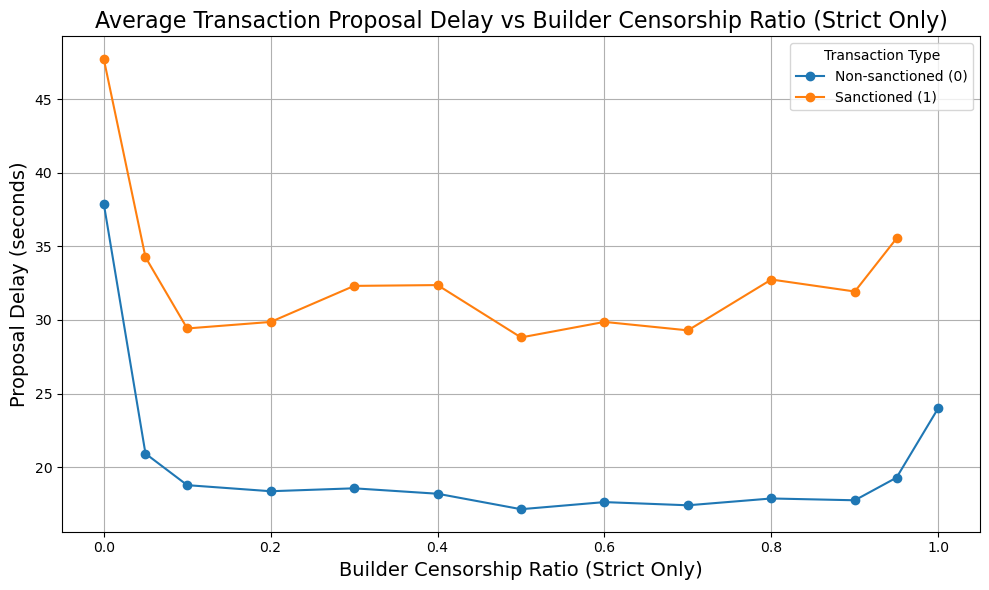

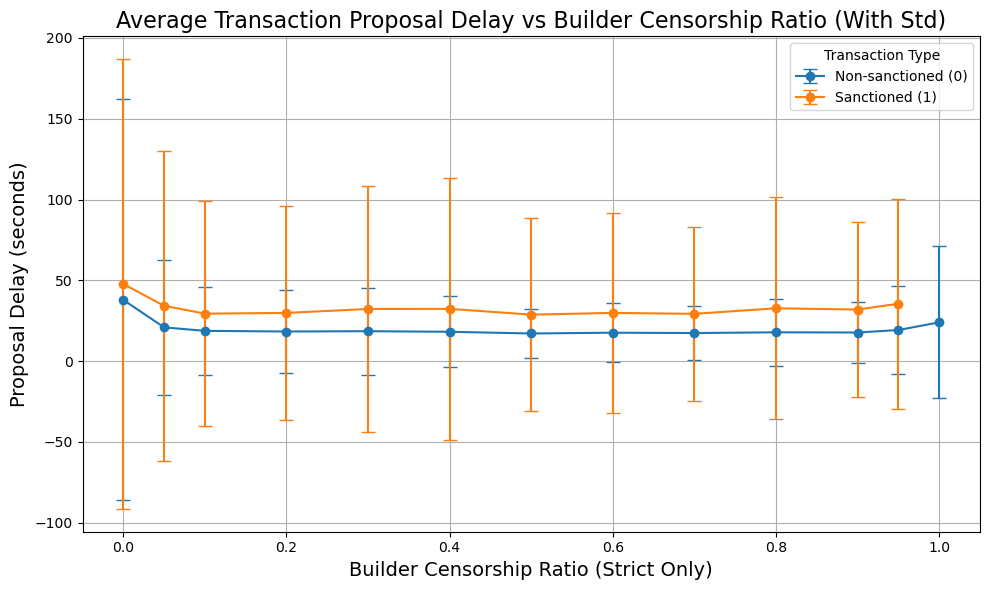

In [ ]:

final_stats['builder_censorship_ratio'] = final_stats['experiment'].str.extract(r'bcr_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['builder_censorship_ratio'], group['mean'], '-o', label=label)

ax.set_xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Censorship Ratio (Strict Only)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['builder_censorship_ratio'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Censorship Ratio (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


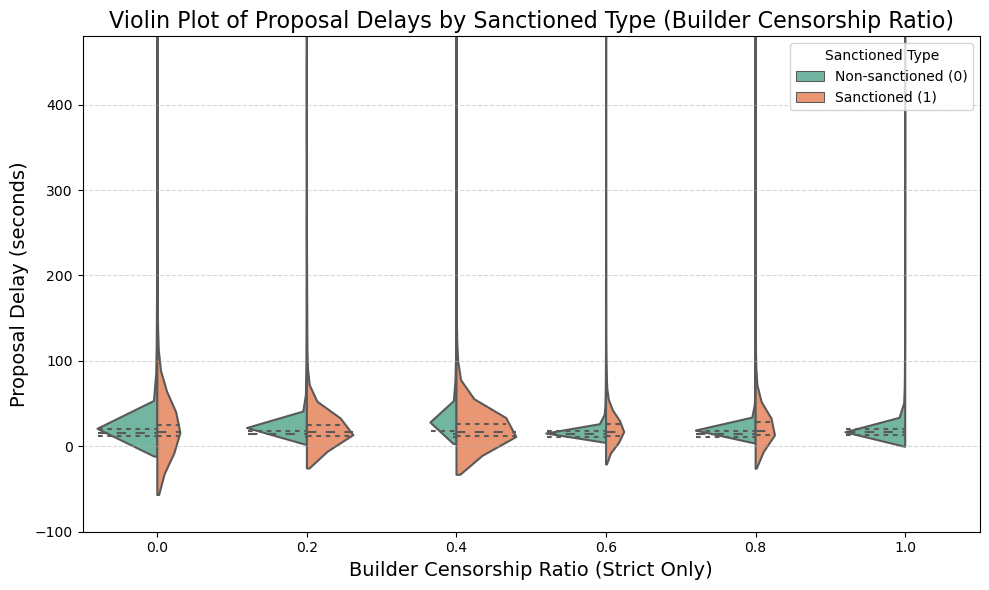

In [ ]:


selected_experiments = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']

plt.figure(figsize=(10, 6))


builder_ratio_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('bcr_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=builder_ratio_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.1f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Builder Censorship Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  builder_censorship_ratio

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_only_strict_builder_censorship_ratio_20250622_083425"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)


results = []

for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

  
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks

     
        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

 
    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'bcr_{builder_ratio:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: bcr_{builder_ratio:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: bcr_0.000
平均含 sanctioned_type=1 交易的区块数量: 144.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 137.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.32%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.68%
平均空区块数量: 18.600000
空区块占所有已提议区块的比例: 6.20%

Experiment: bcr_0.050
平均含 sanctioned_type=1 交易的区块数量: 143.300000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 154.400000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.15%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.85%
平均空区块数量: 2.300000
空区块占所有已提议区块的比例: 0.77%

Experiment: bcr_0.100
平均含 sanctioned_type=1 交易的区块数量: 142.500000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 156.400000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 47.67%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 52.33%
平均空区块数量: 1.100000
空区块占所有已提议区块的比例: 0.37%

Experiment: bcr_0.200
平均含 sanctioned_type=1 交易的区块数量: 141.000000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 158.300000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 47.11%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 52.89%
平均空区块数量: 0.700000
空区块占所有已提议区块的比例: 0.23%

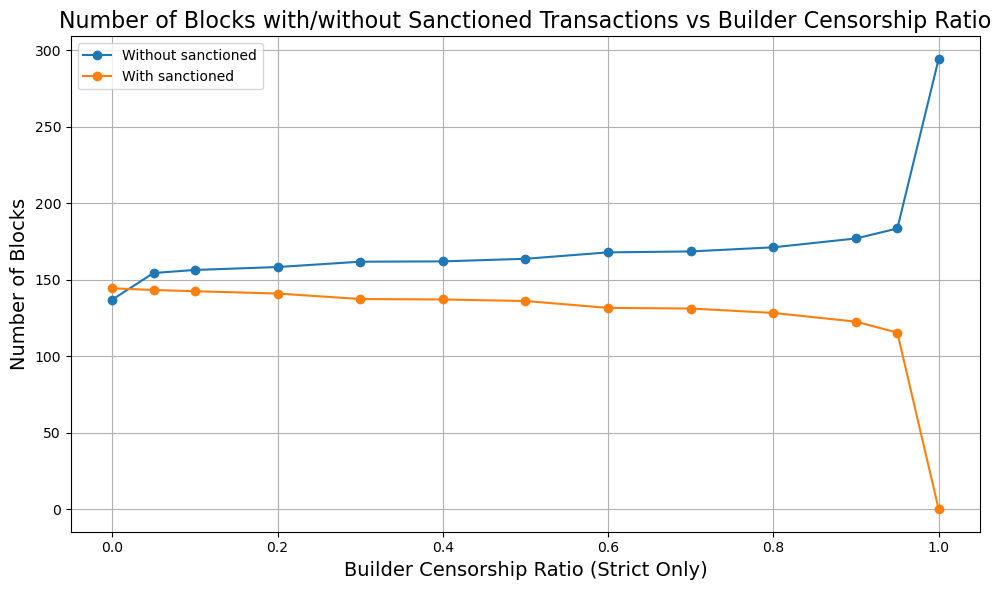

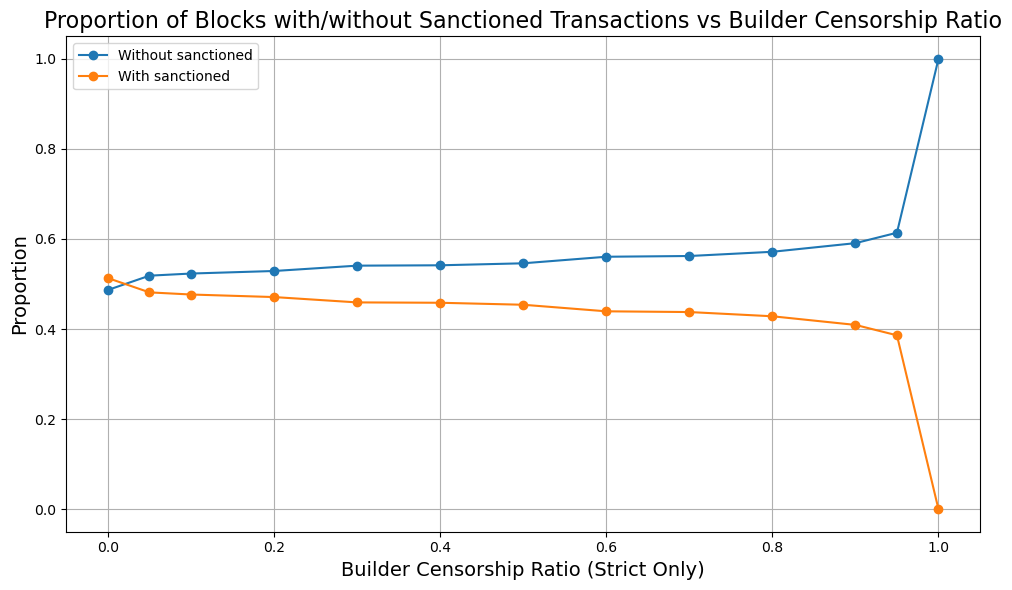

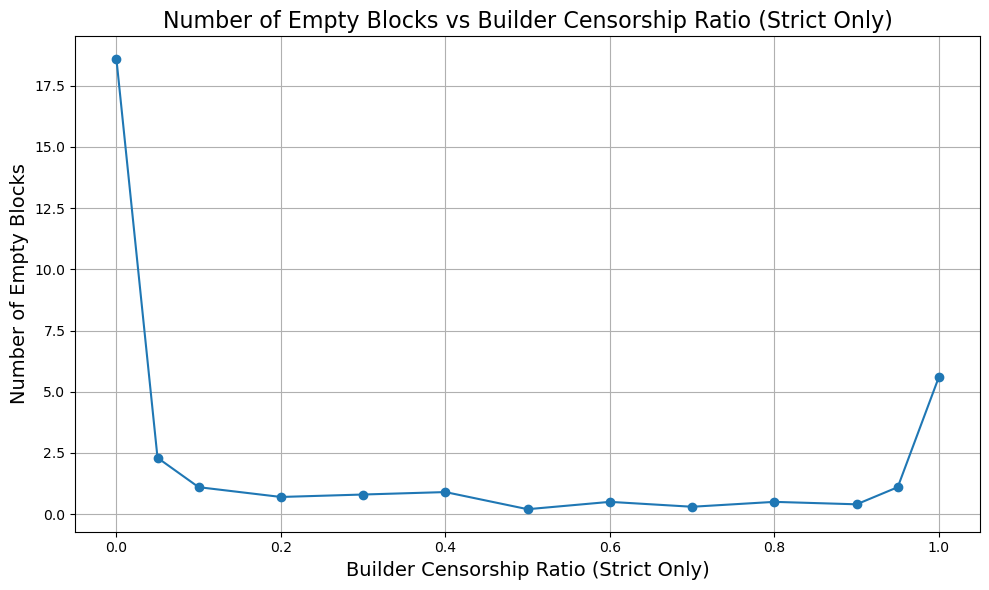

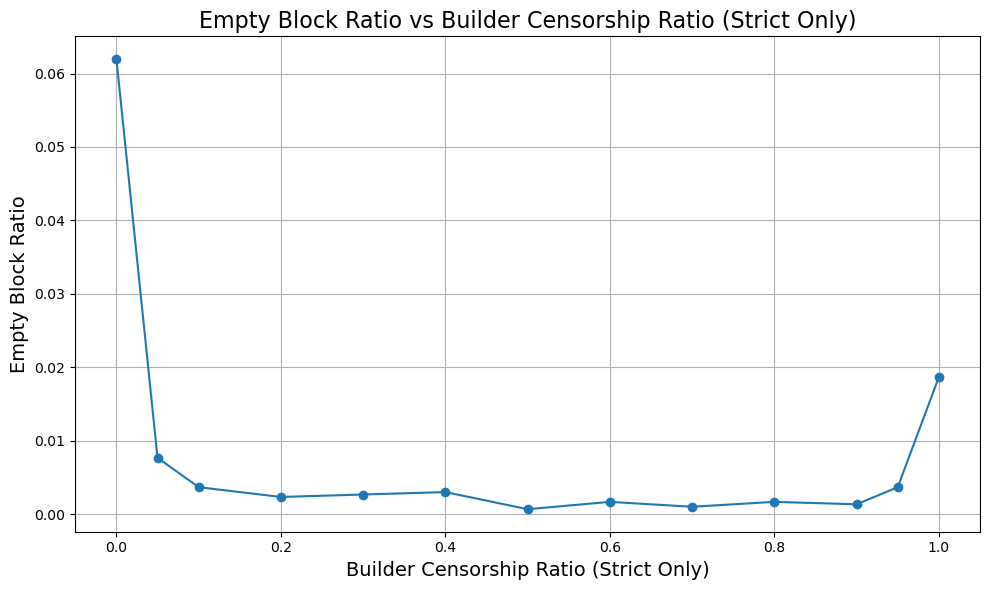

In [ ]:

results_df = pd.DataFrame(results)
results_df['builder_ratio'] = results_df['experiment'].str.extract(r'bcr_(\d+\.\d+)').astype(float)

# Figure 1: Number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_ratio'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Builder Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_ratio'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Builder Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Average number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Builder Censorship Ratio (Strict Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Builder Censorship Ratio (Strict Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### total_block_value，mean_block_value  - builder_censorship_ratio

In [ ]:
# calculate_block_value_stats函数定义

def calculate_block_value_stats(exp_blocks, builder_ratio):
    
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()


    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']


    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

  
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'builder_ratio': builder_ratio,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同builder_censorship_ratio参数下的总区块价值和平均区块价值:
    builder_ratio  avg_total_block_value  avg_mean_block_value  \
0            0.00           1.185579e+10          4.214063e+07   
1            0.05           1.190761e+10          3.999974e+07   
2            0.10           1.190654e+10          3.983525e+07   
3            0.20           1.190780e+10          3.978606e+07   
4            0.30           1.190815e+10          3.980055e+07   
5            0.40           1.190855e+10          3.981581e+07   
6            0.50           1.190794e+10          3.971982e+07   
7            0.60           1.190798e+10          3.976010e+07   
8            0.70           1.190840e+10          3.973452e+07   
9            0.80           1.190826e+10          3.976086e+07   
10           0.90           1.190770e+10          3.974567e+07   
11           0.95           1.190740e+10          3.983926e+07   
12           1.00           1.183713e+10          4.021274e+07   

    avg_total_block_value_eth  

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


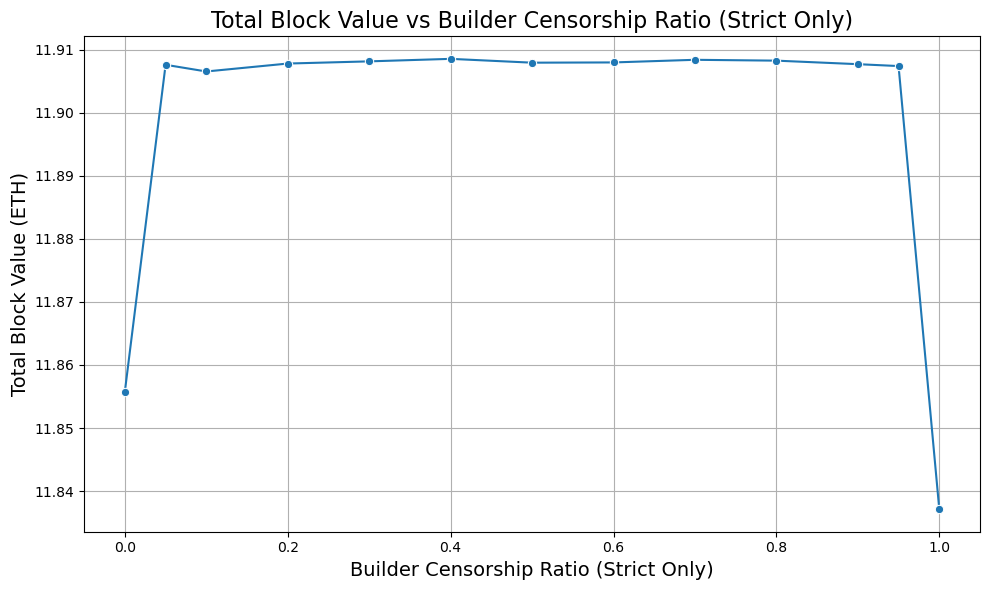

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


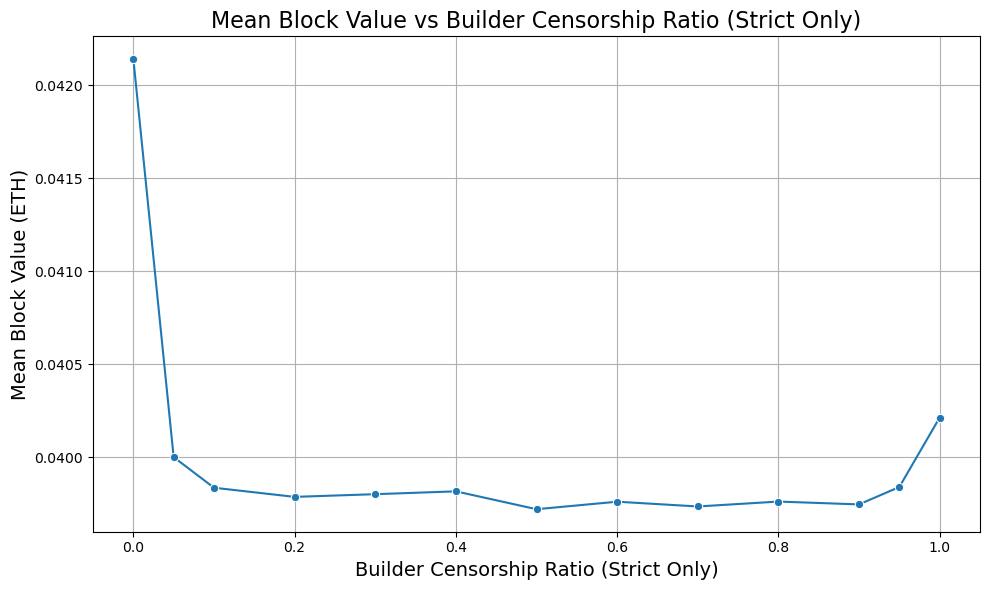

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_only_strict_builder_censorship_ratio_20250622_083425"


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]
folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)


    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()


    stats = calculate_block_value_stats(blocks, builder_ratio)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同builder_censorship_ratio参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('builder_ratio'))

# Figure 1: Total block value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Builder Censorship Ratio (Strict Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean block value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Builder Censorship Ratio (Strict Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types  - builder_censorship_ratio

In [ ]:
# Calculate builder profit by policy

def calculate_builder_profit_by_policy(exp_blocks, experiment_name):

    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()


    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )


    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()


    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.002107   
1         strict                            0.000000   
2           weak                            0.000000   
0            non                            0.002051   
1         strict                            0.001650   
2           weak                            0.000000   
0            non                            0.002041   
1         strict                            0.001674   
2           weak                            0.000000   
0            non                            0.002041   
1         strict                            0.001739   
2           weak                            0.000000   
0            non                            0.002044   
1         strict                            0.001787   
2           weak                            0.000000   
0            non                            0.002040   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

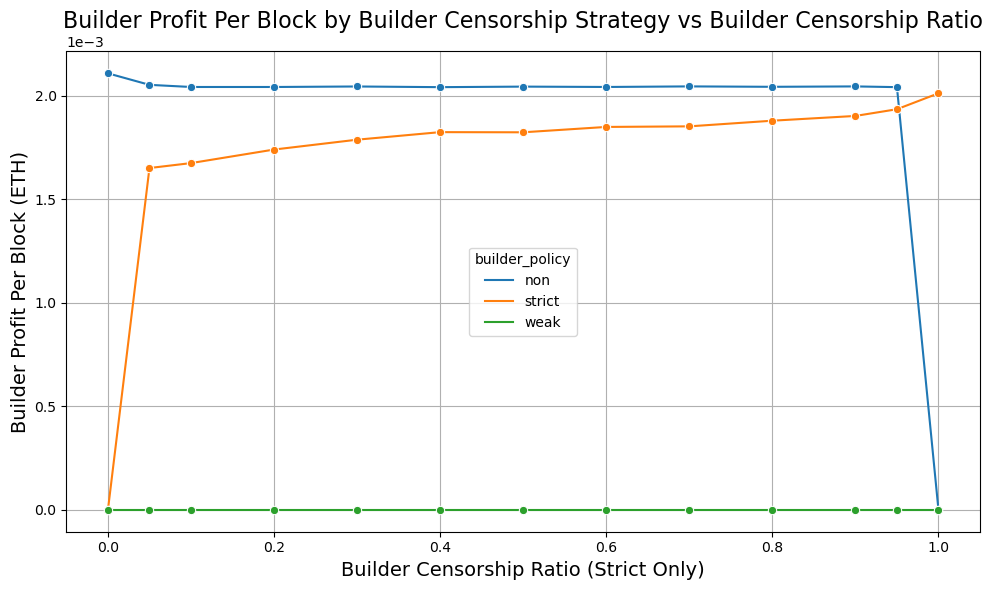

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

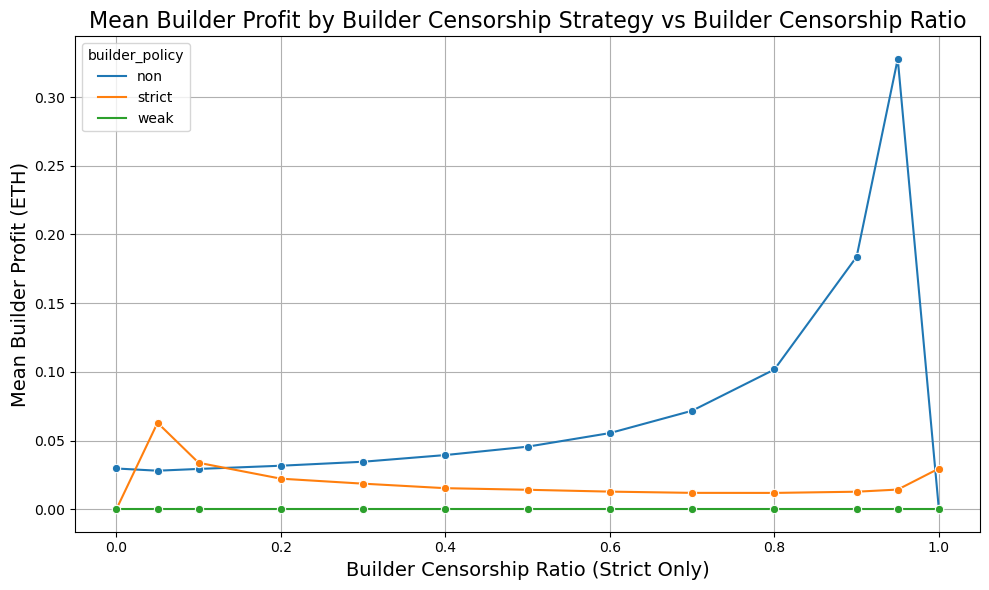

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_only_strict_builder_censorship_ratio_20250622_083425"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)


    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()


    stats = calculate_builder_profit_by_policy(blocks, f'bcr_{builder_ratio:.3f}')
    stats['builder_ratio'] = builder_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_ratio', 'builder_policy']))

# Figure 1: Builder Profit Per Block by Builder Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Builder Profit Per Builder by Builder Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for validators under different censorship types  - builder_censorship_ratio

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.041225   
1                             True                              0.032791   
0                            False                              0.039554   
1                             True                              0.031336   
0                            False                              0.039331   
1                             True                              0.031632   
0                            False                              0.039236   
1                             True                              0.031826   
0                            False                              0.039245   
1                             True                              0.031863   
0                            False                              0.039250   
1                             True                              0.031902   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

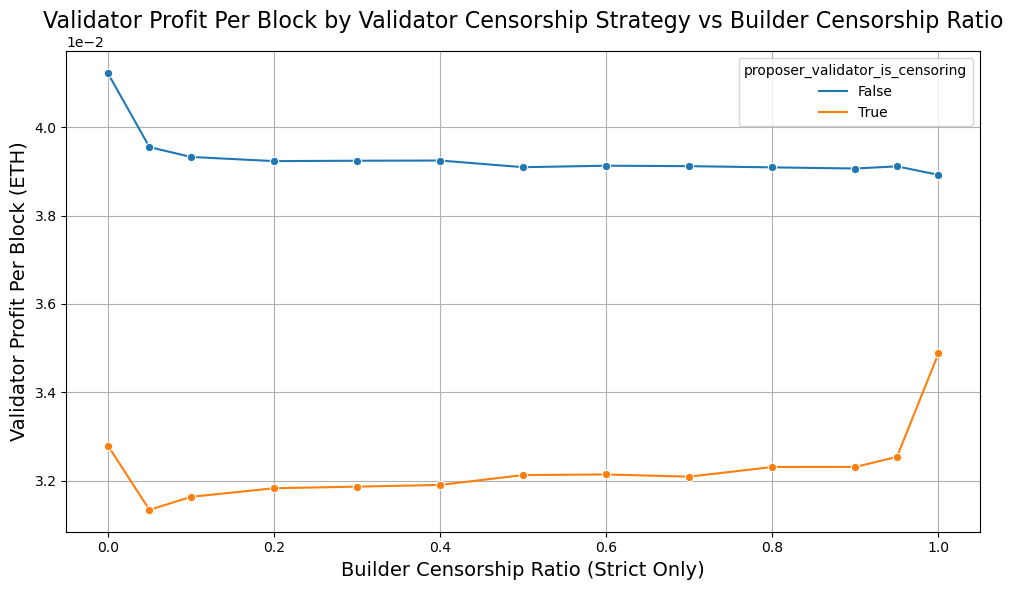

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

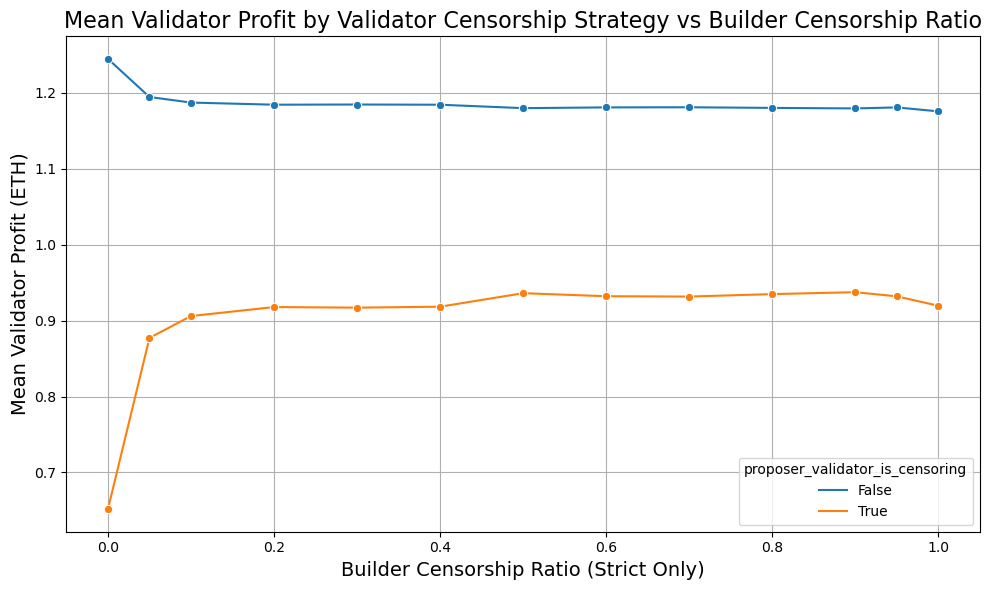

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_only_strict_builder_censorship_ratio_20250622_083425"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

  
    stats = calculate_validator_profit_by_policy(blocks, f'bcr_{builder_ratio:.3f}')
    stats['builder_ratio'] = builder_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_ratio', 'proposer_validator_is_censoring']))

# Figure 1: Validator Profit Per Block by Validator Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Validator Profit Per Validator by Validator Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Censorship Ratio (Strict Only)', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Transaction Delay - builder_censorship_ratio (只有一种weak censoring builders, strict_builder_ratio=0)

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_only_weak_builder_censorship_ratio_20250622_111337"


combined_transactions = pd.DataFrame()


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "transactions.csv")

    transactions = pd.read_csv(file_path, low_memory=False)
    transactions = transactions[transactions['is_proposed']].copy()
    transactions['proposal_delay'] = transactions['proposed_time'] - transactions['arrival_time']
    transactions['sanctioned_type'] = transactions['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    transactions['experiment'] = f"bcr_{builder_ratio:.3f}"

    combined_transactions = pd.concat([combined_transactions, transactions], ignore_index=True)


negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)


run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("\nProposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]

Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
   experiment     sanctioned_type       mean         std
0   bcr_0.000  Non-sanctioned (0)  37.911197  124.084247
1   bcr_0.000      Sanctioned (1)  47.741898  139.324714
2   bcr_0.050  Non-sanctioned (0)  36.702325  120.549170
3   bcr_0.050      Sanctioned (1)  51.963509  176.935176
4   bcr_0.100  Non-sanctioned (0)  32.900769   98.576175
5   bcr_0.100      Sanctioned (1)  44.378284  127.588559
6   bcr_0.200  Non-sanctioned 

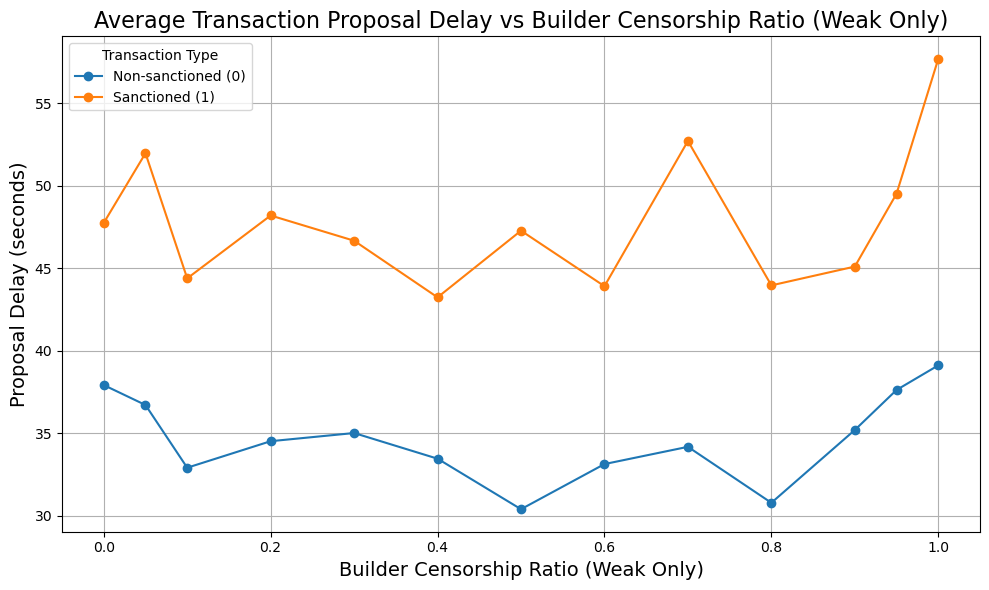

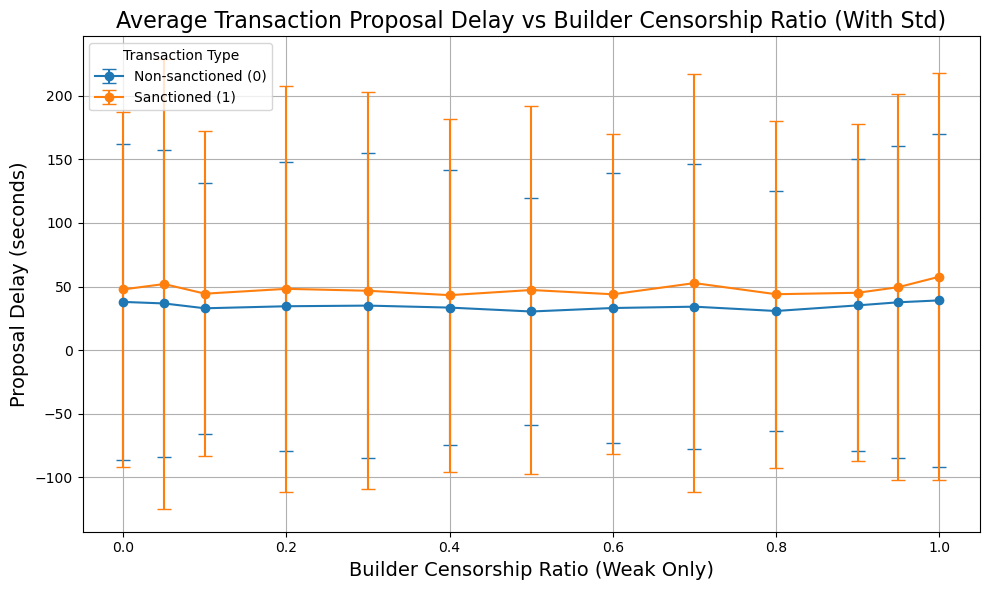

In [ ]:

final_stats['builder_censorship_ratio'] = final_stats['experiment'].str.extract(r'bcr_(\d+\.\d+)').astype(float)


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.plot(group['builder_censorship_ratio'], group['mean'], '-o', label=label)

ax.set_xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Censorship Ratio (Weak Only)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(10, 6))
for label, group in final_stats.groupby('sanctioned_type'):
    ax.errorbar(group['builder_censorship_ratio'], group['mean'], yerr=group['std'],
                fmt='-o', label=label, capsize=5)

ax.set_xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
ax.set_ylabel('Proposal Delay (seconds)', fontsize=14)
ax.set_title('Average Transaction Proposal Delay vs Builder Censorship Ratio (With Std)', fontsize=16)
ax.legend(title='Transaction Type')
ax.grid(True)
plt.tight_layout()
plt.show()


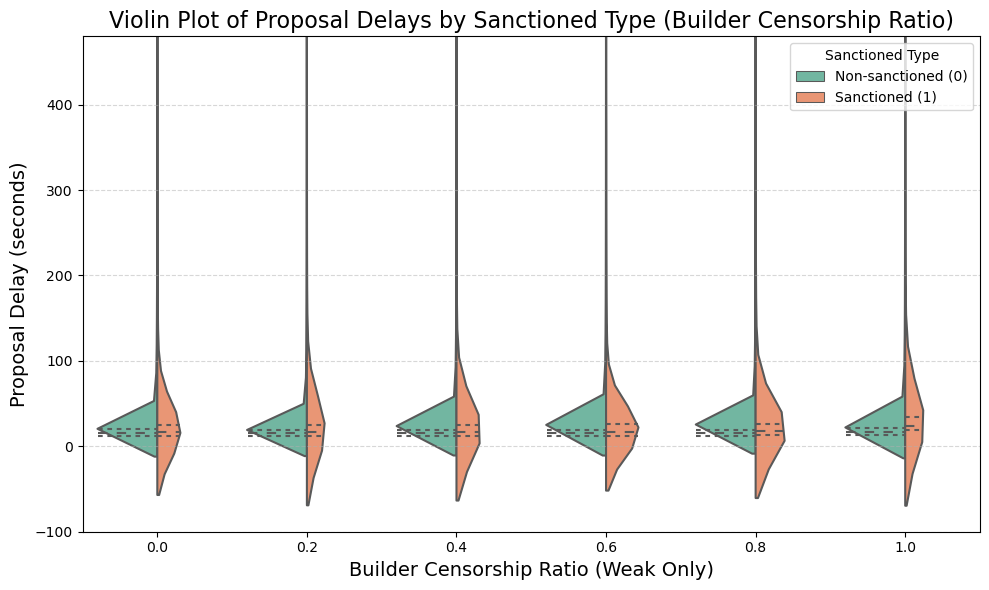

In [ ]:


selected_experiments = ['0.000', '0.200', '0.400', '0.600', '0.800', '1.000']

plt.figure(figsize=(10, 6))


builder_ratio_filtered = combined_transactions[
    combined_transactions['experiment'].str.contains('bcr_') &
    combined_transactions['experiment'].str[-5:].isin(selected_experiments)
]

sns.violinplot(
    data=builder_ratio_filtered,
    x='experiment',
    y='proposal_delay',
    hue='sanctioned_type',
    split=True,
    inner='quartile',
    palette='Set2',
    clip=(0, 480),
)


current_labels = plt.gca().get_xticklabels()
new_labels = [f"{float(label.get_text()[-5:]):.1f}" for label in current_labels]
plt.gca().set_xticklabels(new_labels)

plt.ylim(-100, 480)
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Violin Plot of Proposal Delays by Sanctioned Type (Builder Censorship Ratio)', fontsize=16)

plt.legend(title='Sanctioned Type', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### The number/proportion of blocks containing sanctioned transactions
#### The number/proportion of empty blocks
#### -  builder_censorship_ratio

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_only_weak_builder_censorship_ratio_20250622_111337"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)


results = []

for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

    run_ids = blocks['run_id'].unique()

  
    run_metrics = []

    for run in run_ids:
        run_blocks = blocks[blocks['run_id'] == run]

        non_empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] != 'PROPOSER')].copy()
        non_empty_blocks['contains_sanctioned'] = non_empty_blocks['num_sanctioned_tx'] > 0

        blocks_with_sanctioned = non_empty_blocks['contains_sanctioned'].sum()
        blocks_without_sanctioned = (~non_empty_blocks['contains_sanctioned']).sum()
        total_non_empty_blocks = len(non_empty_blocks)

        empty_blocks = run_blocks[(run_blocks['is_proposed']) & (run_blocks['builder_id'] == 'PROPOSER')]
        total_empty_blocks = empty_blocks.shape[0]
        total_proposed_blocks = total_non_empty_blocks + total_empty_blocks


        ratio_with_sanctioned = blocks_with_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        ratio_without_sanctioned = blocks_without_sanctioned / total_non_empty_blocks if total_non_empty_blocks > 0 else 0
        empty_block_ratio = total_empty_blocks / total_proposed_blocks if total_proposed_blocks > 0 else 0

        run_metrics.append({
            'blocks_with_sanctioned': blocks_with_sanctioned,
            'blocks_without_sanctioned': blocks_without_sanctioned,
            'empty_blocks': total_empty_blocks,
            'ratio_with_sanctioned': ratio_with_sanctioned,
            'ratio_without_sanctioned': ratio_without_sanctioned,
            'empty_block_ratio': empty_block_ratio
        })

    
    metrics_df = pd.DataFrame(run_metrics)

    results.append({
        'experiment': f'bcr_{builder_ratio:.3f}',
        'avg_blocks_with_sanctioned': metrics_df['blocks_with_sanctioned'].mean(),
        'avg_blocks_without_sanctioned': metrics_df['blocks_without_sanctioned'].mean(),
        'ratio_with_sanctioned': metrics_df['ratio_with_sanctioned'].mean(),
        'ratio_without_sanctioned': metrics_df['ratio_without_sanctioned'].mean(),
        'avg_empty_blocks': metrics_df['empty_blocks'].mean(),
        'empty_block_ratio': metrics_df['empty_block_ratio'].mean()
    })

    print(f"\nExperiment: bcr_{builder_ratio:.3f}")
    print(f"平均含 sanctioned_type=1 交易的区块数量: {metrics_df['blocks_with_sanctioned'].mean():.6f}")
    print(f"平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: {metrics_df['blocks_without_sanctioned'].mean():.6f}")
    print(f"含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_with_sanctioned'].mean():.2%}")
    print(f"不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: {metrics_df['ratio_without_sanctioned'].mean():.2%}")
    print(f"平均空区块数量: {metrics_df['empty_blocks'].mean():.6f}")
    print(f"空区块占所有已提议区块的比例: {metrics_df['empty_block_ratio'].mean():.2%}")



Experiment: bcr_0.000
平均含 sanctioned_type=1 交易的区块数量: 144.400000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 137.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 51.32%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 48.68%
平均空区块数量: 18.600000
空区块占所有已提议区块的比例: 6.20%

Experiment: bcr_0.050
平均含 sanctioned_type=1 交易的区块数量: 143.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 139.000000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.86%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.14%
平均空区块数量: 17.200000
空区块占所有已提议区块的比例: 5.73%

Experiment: bcr_0.100
平均含 sanctioned_type=1 交易的区块数量: 143.700000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 140.800000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.50%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.50%
平均空区块数量: 15.500000
空区块占所有已提议区块的比例: 5.17%

Experiment: bcr_0.200
平均含 sanctioned_type=1 交易的区块数量: 143.800000
平均不含 sanctioned_type=1 交易的区块数量（不含空区块）: 142.800000
含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 50.16%
不含 sanctioned_type=1 交易的区块占所有已提议非空区块的比例: 49.84%
平均空区块数量: 13.400000
空区块占所有已提议区块的比例: 4.

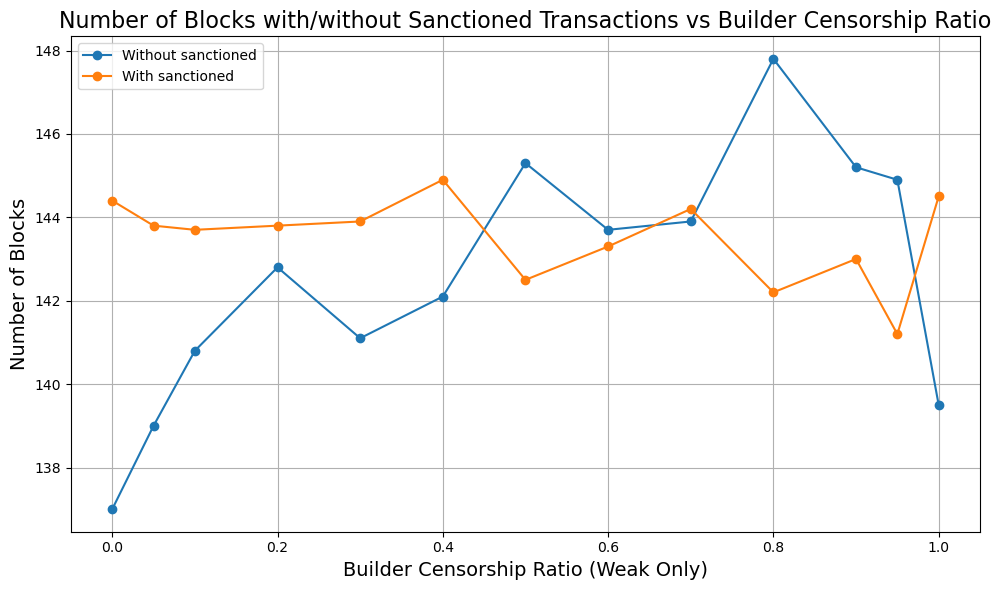

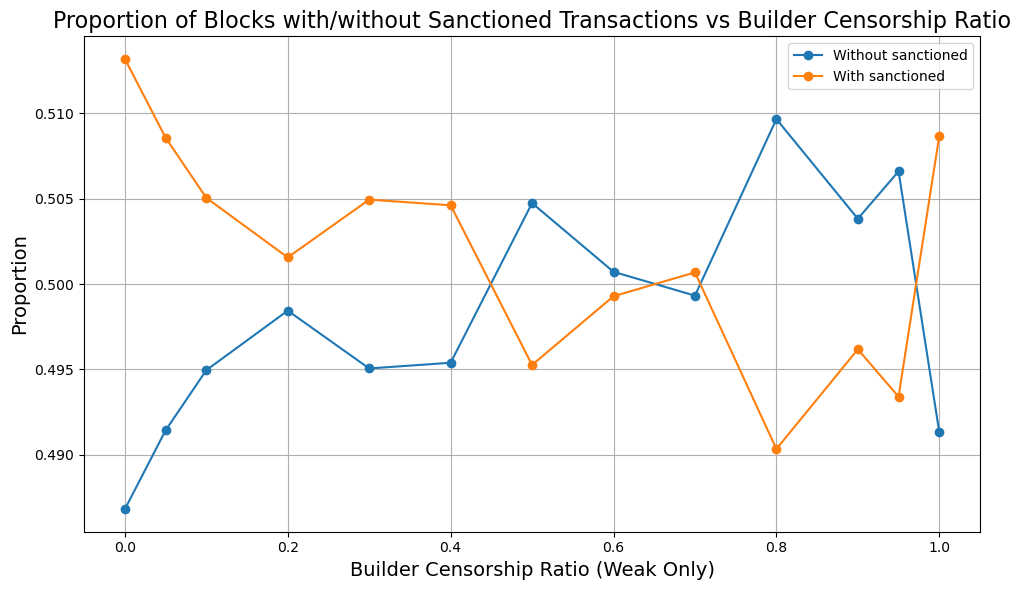

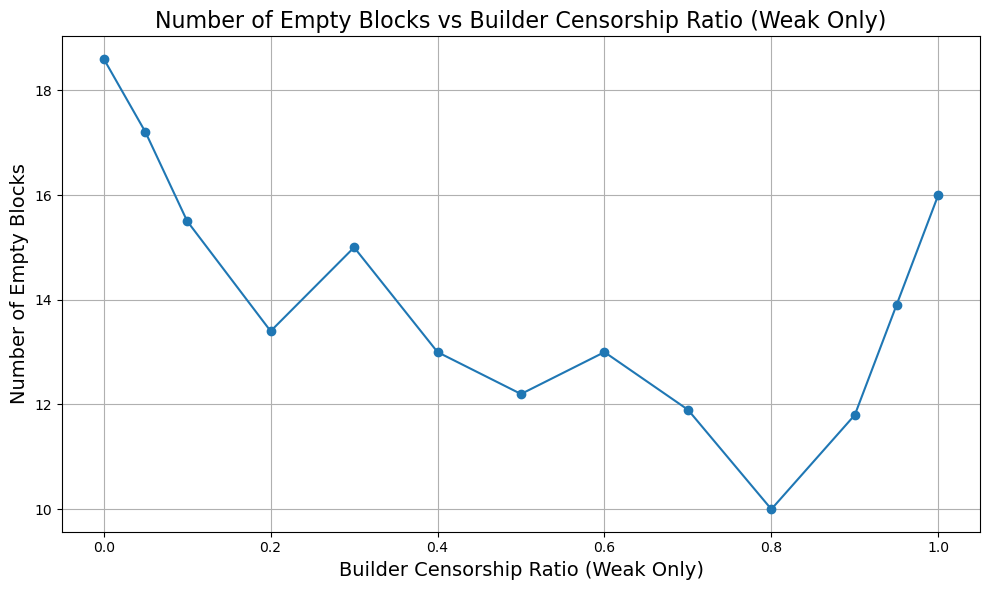

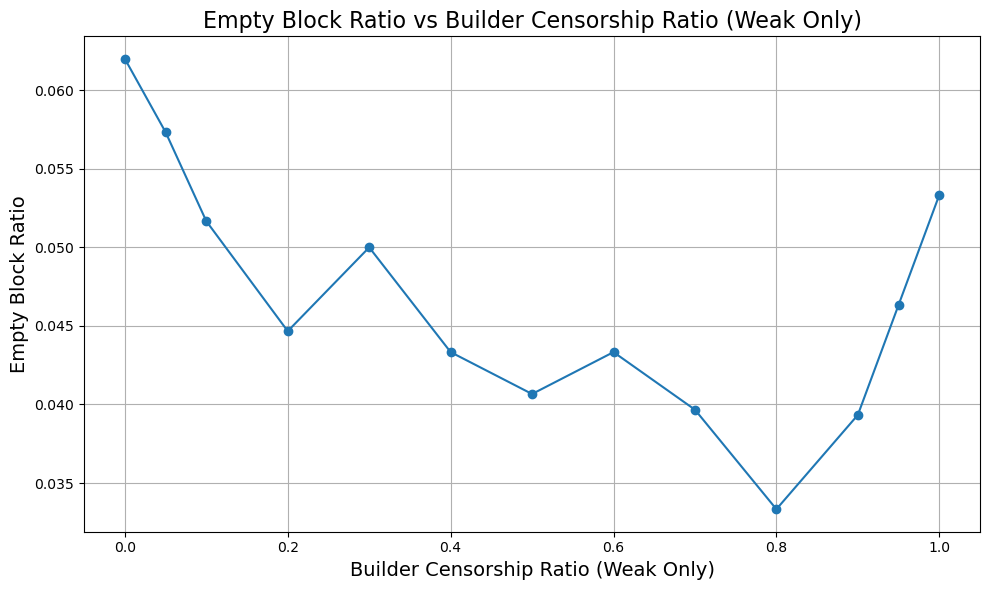

In [ ]:

results_df = pd.DataFrame(results)
results_df['builder_ratio'] = results_df['experiment'].str.extract(r'bcr_(\d+\.\d+)').astype(float)

# Figure 1: Number of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['avg_blocks_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_ratio'], results_df['avg_blocks_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Number of Blocks', fontsize=14)
plt.title('Number of Blocks with/without Sanctioned Transactions vs Builder Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Proportion of blocks with/without sanctioned transactions
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['ratio_without_sanctioned'], marker='o', label='Without sanctioned')
plt.plot(results_df['builder_ratio'], results_df['ratio_with_sanctioned'], marker='o', label='With sanctioned')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.title('Proportion of Blocks with/without Sanctioned Transactions vs Builder Censorship Ratio', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 3: Average number of empty blocks
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['avg_empty_blocks'], marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Number of Empty Blocks', fontsize=14)
plt.title('Number of Empty Blocks vs Builder Censorship Ratio (Weak Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 4: Empty block ratio
plt.figure(figsize=(10, 6))
plt.plot(results_df['builder_ratio'], results_df['empty_block_ratio'], marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Empty Block Ratio', fontsize=14)
plt.title('Empty Block Ratio vs Builder Censorship Ratio (Weak Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### total_block_value，mean_block_value  - builder_censorship_ratio

In [ ]:
# calculate_block_value_stats

def calculate_block_value_stats(exp_blocks, builder_ratio):
    
    run_summary = exp_blocks.groupby('run_id').agg(
        total_block_value=('total_priority_fee', 'sum'),
        num_blocks=('block_id', 'count')
    ).reset_index()

   
    run_summary['mean_block_value'] = run_summary['total_block_value'] / run_summary['num_blocks']


    avg_total_block_value = run_summary['total_block_value'].mean()
    avg_mean_block_value = run_summary['mean_block_value'].mean()

    
    avg_total_block_value_eth = avg_total_block_value * 1e-9
    avg_mean_block_value_eth = avg_mean_block_value * 1e-9

    return {
        'builder_ratio': builder_ratio,
        'avg_total_block_value': avg_total_block_value,
        'avg_mean_block_value': avg_mean_block_value,
        'avg_total_block_value_eth': avg_total_block_value_eth,
        'avg_mean_block_value_eth': avg_mean_block_value_eth
    }


不同builder_censorship_ratio参数下的总区块价值和平均区块价值:
    builder_ratio  avg_total_block_value  avg_mean_block_value  \
0            0.00           1.185579e+10          4.214063e+07   
1            0.05           1.186498e+10          4.196891e+07   
2            0.10           1.187301e+10          4.174288e+07   
3            0.20           1.187978e+10          4.146205e+07   
4            0.30           1.187200e+10          4.166644e+07   
5            0.40           1.188058e+10          4.141285e+07   
6            0.50           1.188595e+10          4.130955e+07   
7            0.60           1.188163e+10          4.140570e+07   
8            0.70           1.188821e+10          4.127197e+07   
9            0.80           1.188999e+10          4.100833e+07   
10           0.90           1.188552e+10          4.124755e+07   
11           0.95           1.187962e+10          4.152679e+07   
12           1.00           1.186647e+10          4.179396e+07   

    avg_total_block_value_eth  

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


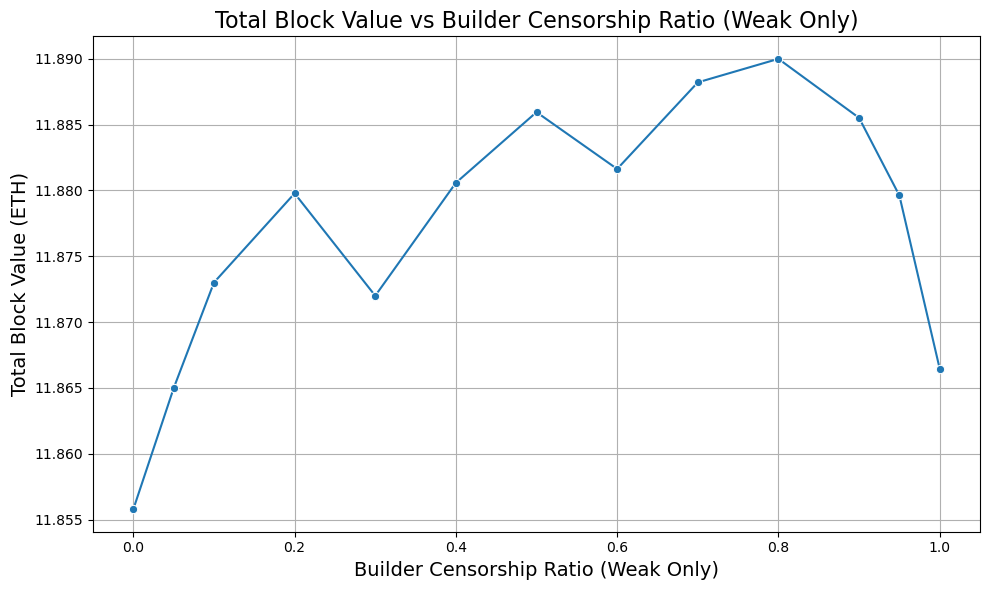

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


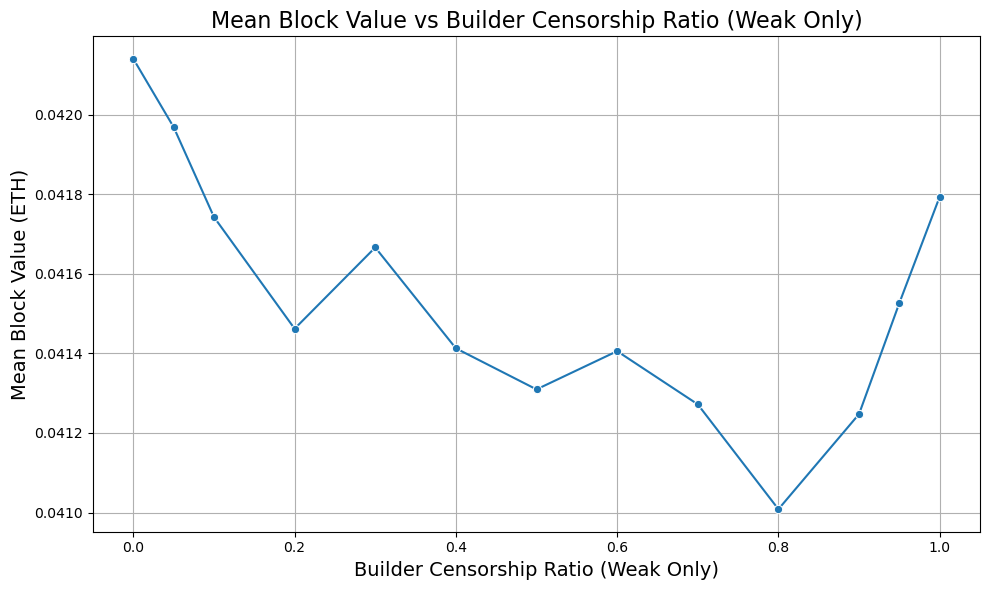

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_only_weak_builder_censorship_ratio_20250622_111337"


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]
folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

 
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()


    stats = calculate_block_value_stats(blocks, builder_ratio)
    results.append(stats)


combined_stats = pd.DataFrame(results)


print("不同builder_censorship_ratio参数下的总区块价值和平均区块价值:")
print(combined_stats.sort_values('builder_ratio'))

# Figure 1: Total block value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='avg_total_block_value_eth', marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Total Block Value (ETH)', fontsize=14)
plt.title('Total Block Value vs Builder Censorship Ratio (Weak Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean block value (ETH)
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='avg_mean_block_value_eth', marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Mean Block Value (ETH)', fontsize=14)
plt.title('Mean Block Value vs Builder Censorship Ratio (Weak Only)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for builders under different censorship types  - builder_censorship_ratio

In [ ]:
# Calculate builder profit by policy

def calculate_builder_profit_by_policy(exp_blocks, experiment_name):

    policy_summary = exp_blocks.groupby(['run_id', 'builder_policy']).agg(
        total_builder_profit=('builder_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_builders=('builder_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = ['strict', 'weak', 'non']
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'builder_policy'])

    policy_summary = policy_summary.set_index(['run_id', 'builder_policy']).reindex(
        full_index, fill_value=0
    ).reset_index()


    policy_summary['mean_profit_per_block'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )
    
    policy_summary['mean_profit_per_builder'] = policy_summary.apply(
        lambda row: row['total_builder_profit'] / row['num_builders'] if row['num_builders'] > 0 else 0, axis=1
    )


    final_policy_avg = policy_summary.groupby('builder_policy').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_builder': 'mean'
    }).reset_index()


    final_policy_avg['mean_builder_profit_per_block(ETH)'] = final_policy_avg['mean_profit_per_block'] * 1e-9
    final_policy_avg['mean_builder_profit_per_builder(ETH)'] = final_policy_avg['mean_profit_per_builder'] * 1e-9

    final_policy_avg['experiment'] = experiment_name

    return final_policy_avg[[
        'builder_policy',
        'mean_builder_profit_per_block(ETH)',
        'mean_builder_profit_per_builder(ETH)',
        'experiment'
    ]]


  builder_policy  mean_builder_profit_per_block(ETH)  \
0            non                            0.002107   
1         strict                            0.000000   
2           weak                            0.000000   
0            non                            0.002117   
1         strict                            0.000000   
2           weak                            0.001795   
0            non                            0.002114   
1         strict                            0.000000   
2           weak                            0.001739   
0            non                            0.002100   
1         strict                            0.000000   
2           weak                            0.001870   
0            non                            0.002111   
1         strict                            0.000000   
2           weak                            0.001904   
0            non                            0.002104   
1         strict                            0.00

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

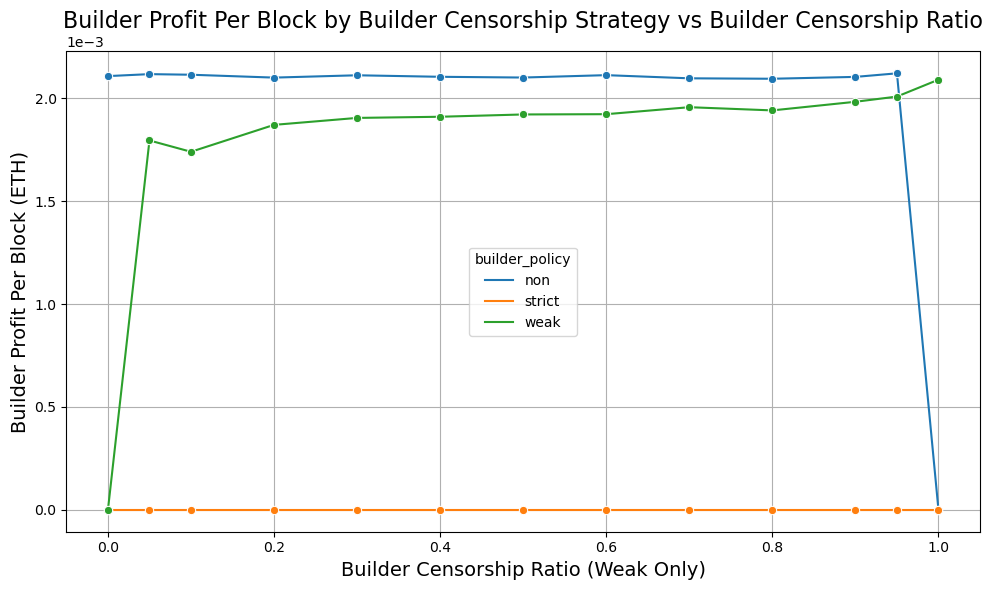

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

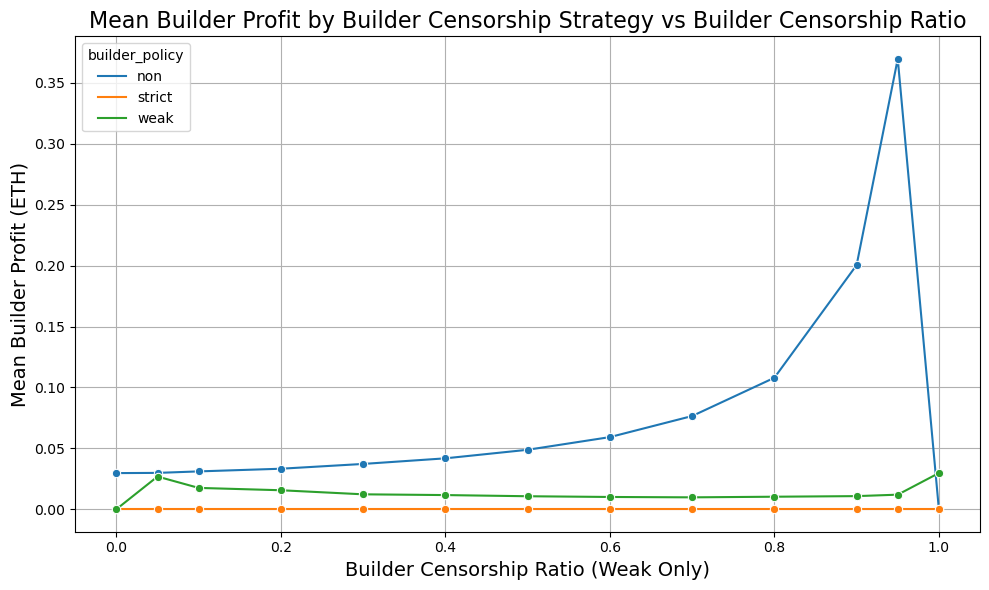

In [ ]:


base_dir = "simulation_results_SA_0608/sensitivity_only_weak_builder_censorship_ratio_20250622_111337"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)


    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()


    stats = calculate_builder_profit_by_policy(blocks, f'bcr_{builder_ratio:.3f}')
    stats['builder_ratio'] = builder_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_ratio', 'builder_policy']))

# Figure 1: Builder Profit Per Block by Builder Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_builder_profit_per_block(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Builder Profit Per Block (ETH)', fontsize=14)
plt.title('Builder Profit Per Block by Builder Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Builder Profit Per Builder by Builder Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_builder_profit_per_builder(ETH)', hue='builder_policy', marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Mean Builder Profit (ETH)', fontsize=14)
plt.title('Mean Builder Profit by Builder Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Average profit (per block & per node) for validators under different censorship types  - builder_censorship_ratio

In [ ]:

# Calculate validator profit by policy

def calculate_validator_profit_by_policy(exp_blocks, experiment_name):
    validator_summary = exp_blocks.groupby(['run_id', 'proposer_validator_is_censoring']).agg(
        total_proposer_profit=('proposer_profit', 'sum'),
        num_blocks=('block_id', 'count'),
        num_validators=('proposer_validator_id', pd.Series.nunique)
    ).reset_index()

    all_run_ids = exp_blocks['run_id'].unique()
    total_runs = len(all_run_ids)

    all_policies = [True, False]
    full_index = pd.MultiIndex.from_product([all_run_ids, all_policies], names=['run_id', 'proposer_validator_is_censoring'])

    validator_summary = validator_summary.set_index(['run_id', 'proposer_validator_is_censoring']).reindex(
        full_index, fill_value=0
    ).reset_index()

    validator_summary['mean_profit_per_block'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_blocks'] if row['num_blocks'] > 0 else 0, axis=1
    )

    validator_summary['mean_profit_per_validator'] = validator_summary.apply(
        lambda row: row['total_proposer_profit'] / row['num_validators'] if row['num_validators'] > 0 else 0, axis=1
    )

    final_validator_avg = validator_summary.groupby('proposer_validator_is_censoring').agg({
        'mean_profit_per_block': 'mean',
        'mean_profit_per_validator': 'mean'
    }).reset_index()

    final_validator_avg['mean_validator_profit_per_block(ETH)'] = final_validator_avg['mean_profit_per_block'] * 1e-9
    final_validator_avg['mean_validator_profit_per_validator(ETH)'] = final_validator_avg['mean_profit_per_validator'] * 1e-9

    final_validator_avg['experiment'] = experiment_name

    return final_validator_avg[[
        'proposer_validator_is_censoring',
        'mean_validator_profit_per_block(ETH)',
        'mean_validator_profit_per_validator(ETH)',
        'experiment'
    ]]


   proposer_validator_is_censoring  mean_validator_profit_per_block(ETH)  \
0                            False                              0.041225   
1                             True                              0.032791   
0                            False                              0.041053   
1                             True                              0.032895   
0                            False                              0.040904   
1                             True                              0.032580   
0                            False                              0.040642   
1                             True                              0.032611   
0                            False                              0.040757   
1                             True                              0.033019   
0                            False                              0.040570   
1                             True                              0.032773   
0           

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

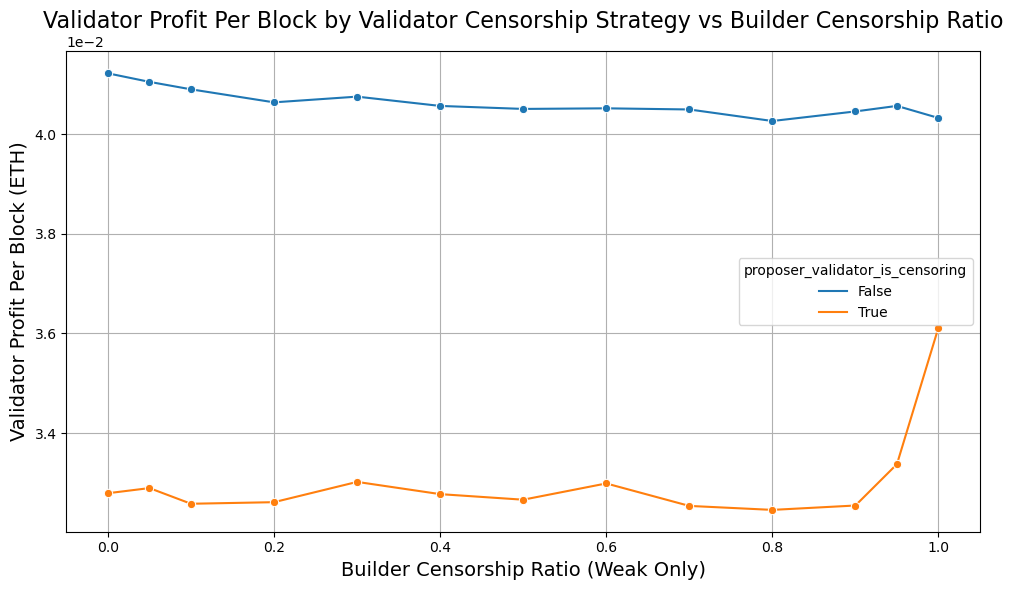

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Future

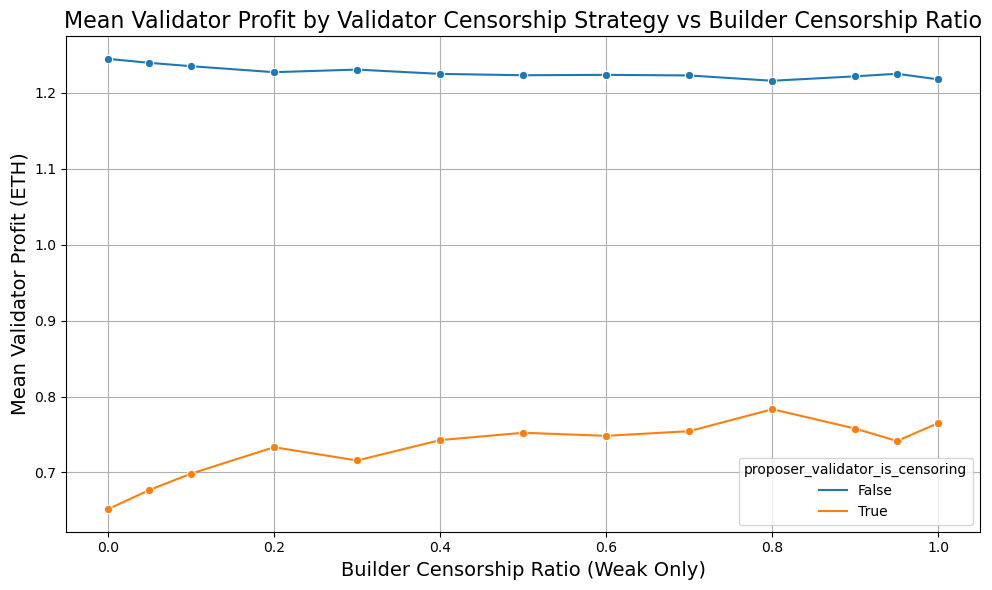

In [ ]:

base_dir = "simulation_results_SA_0608/sensitivity_only_weak_builder_censorship_ratio_20250622_111337"


folders = [f for f in os.listdir(base_dir) if f.startswith("builder_censorship_ratio_")]


def extract_builder_ratio(folder_name):
    match = re.search(r"builder_censorship_ratio_(\d+\.\d+)_", folder_name)
    return float(match.group(1)) if match else float('inf')

folders.sort(key=extract_builder_ratio)

results = []


for folder in folders:
    builder_ratio = extract_builder_ratio(folder)
    folder_path = os.path.join(base_dir, folder)
    file_path = os.path.join(folder_path, "blocks.csv")

    blocks = pd.read_csv(file_path, low_memory=False)

  
    blocks = blocks[(blocks['is_proposed']) & (blocks['builder_id'] != 'PROPOSER')].copy()

    
    stats = calculate_validator_profit_by_policy(blocks, f'bcr_{builder_ratio:.3f}')
    stats['builder_ratio'] = builder_ratio
    results.append(stats)


combined_stats = pd.concat(results)


print(combined_stats.sort_values(['builder_ratio', 'proposer_validator_is_censoring']))

# Figure 1: Validator Profit Per Block by Validator Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_validator_profit_per_block(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Validator Profit Per Block (ETH)', fontsize=14)
plt.title('Validator Profit Per Block by Validator Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.grid(True)
plt.tight_layout()
plt.show()

# Figure 2: Mean Validator Profit Per Validator by Validator Censorship Strategy vs Builder Censorship Ratio
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_stats, x='builder_ratio', y='mean_validator_profit_per_validator(ETH)', hue='proposer_validator_is_censoring', marker='o')
plt.xlabel('Builder Censorship Ratio (Weak Only)', fontsize=14)
plt.ylabel('Mean Validator Profit (ETH)', fontsize=14)
plt.title('Mean Validator Profit by Validator Censorship Strategy vs Builder Censorship Ratio', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()
